# Vision Transformer from Scratch with PyTorch

<hr style="border:1px solid #ccc">

## 👨‍💻 Author: **Muhammad Haweras**

[![LinkedIn](https://img.shields.io/badge/LinkedIn-blue?logo=linkedin&logoColor=white)](https://www.linkedin.com/in/muhammad-haweras-7aa6b11b2/)
[![GitHub](https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white)](https://github.com/MuhammadHaweras)

<hr style="border:1px solid #ccc">

## Importing Libraries

In [22]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn

In [23]:
#transformation of PIL data into tensor format
transformation_operation = transforms.Compose([transforms.ToTensor()])

### Loading MNIST Dataset

In [24]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True,transform=transformation_operation,download=True)
val_dataset = torchvision.datasets.MNIST(root='./data',train=False,transform=transformation_operation,download=True)

### Define Hyperparameters (you can play with it)

In [25]:
batch_size = 64
num_classes = 10
img_size = 28
patch_size = 7
num_channels = 1
patch_num = (img_size // patch_size) ** 2

attention_heads = 4
embed_dim = 20

tranformer_blocks = 4
mlp_nodes = 64


In [27]:
train_data = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_data = dataloader.DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [10]:
#to print dimensions
images, labels = next(iter(train_data))
print("Shape of input image  Tensor")
print(images.shape)
patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size,stride=patch_size)
print("Patch Embedded image shape")
print(patch_embed(images).flatten(2).transpose(1,2).shape) # to make in desired vector embedding notation

Shape of input image  Tensor
torch.Size([64, 1, 28, 28])
Patch Embedded image shape
torch.Size([64, 16, 20])


## Class for Patch Embedding - Part 1 of the ViT architecture

In [28]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size,stride=patch_size)

  def forward(self, x):
    return self.patch_embed(x).flatten(2).transpose(1,2)

## Class for Transformer encoder - Part 2 of the ViT architecture



*   Layer Normalization
*   Multi Head Attention
*   Layer Normalization
*   Residuals

*   MLP

*   Actiavtion Function
*   List item

In [47]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.multi_head_attention = nn.MultiheadAttention(embed_dim, attention_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim, mlp_nodes),
        nn.GELU(),
        nn.Linear(mlp_nodes, embed_dim)
    )

  def forward(self, x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multi_head_attention(x, x, x)[0] + residual1
    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x) + residual2
    return x

## Class for MLP head for classifiction - Part 3 of ViT architecture

In [48]:
class MLPHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm3 = nn.LayerNorm(embed_dim)
    self.mlphead = nn.Sequential(
        nn.Linear(embed_dim, num_classes)
    )

  def forward(self, x):
    # x = x[:, 0]
    x = self.layer_norm3(x)
    x = self.mlphead(x)
    return x

## Combining All above Classes to code VisionTransformer Class

In [49]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1, embed_dim))
    self.pos_embedding = nn.Parameter(torch.randn(1,patch_num+1, embed_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(tranformer_blocks)])
    self.mlp_head = MLPHead()

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.size(0)
    cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.pos_embedding
    x = self.transformer_blocks(x)
    x = x[:,0]
    x = self.mlp_head(x)

    return x


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Model Training

Epoch [1/10], Train Accuracy: 98.18%, Validation Accuracy: 97.24%
Epoch [2/10], Train Accuracy: 98.37%, Validation Accuracy: 97.65%
Epoch [3/10], Train Accuracy: 98.40%, Validation Accuracy: 97.72%
Epoch [4/10], Train Accuracy: 98.55%, Validation Accuracy: 97.86%
Epoch [5/10], Train Accuracy: 98.62%, Validation Accuracy: 97.71%
Epoch [6/10], Train Accuracy: 98.75%, Validation Accuracy: 97.46%
Epoch [7/10], Train Accuracy: 98.77%, Validation Accuracy: 97.56%
Epoch [8/10], Train Accuracy: 98.80%, Validation Accuracy: 97.78%
Epoch [9/10], Train Accuracy: 98.87%, Validation Accuracy: 98.07%
Epoch [10/10], Train Accuracy: 99.00%, Validation Accuracy: 97.81%

Final Results:
Final Training Accuracy: 99.00%
Final Validation Accuracy: 97.81%


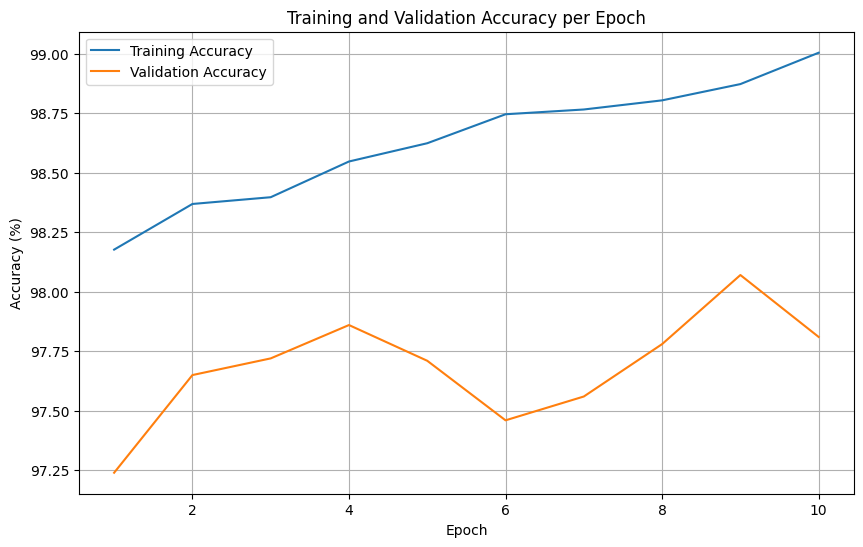

In [55]:

# Store training and validation accuracies
train_accuracies = []
val_accuracies = []
epochs = 10

for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for images, labels in train_data:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predictions = outputs.argmax(dim=1)
        correct_train += (predictions == labels).sum().item()
        total_train += predictions.size(0)

    train_accuracy = 100.0 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_data:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100.0 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

print("\nFinal Results:")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


### Plotting Predicted Images

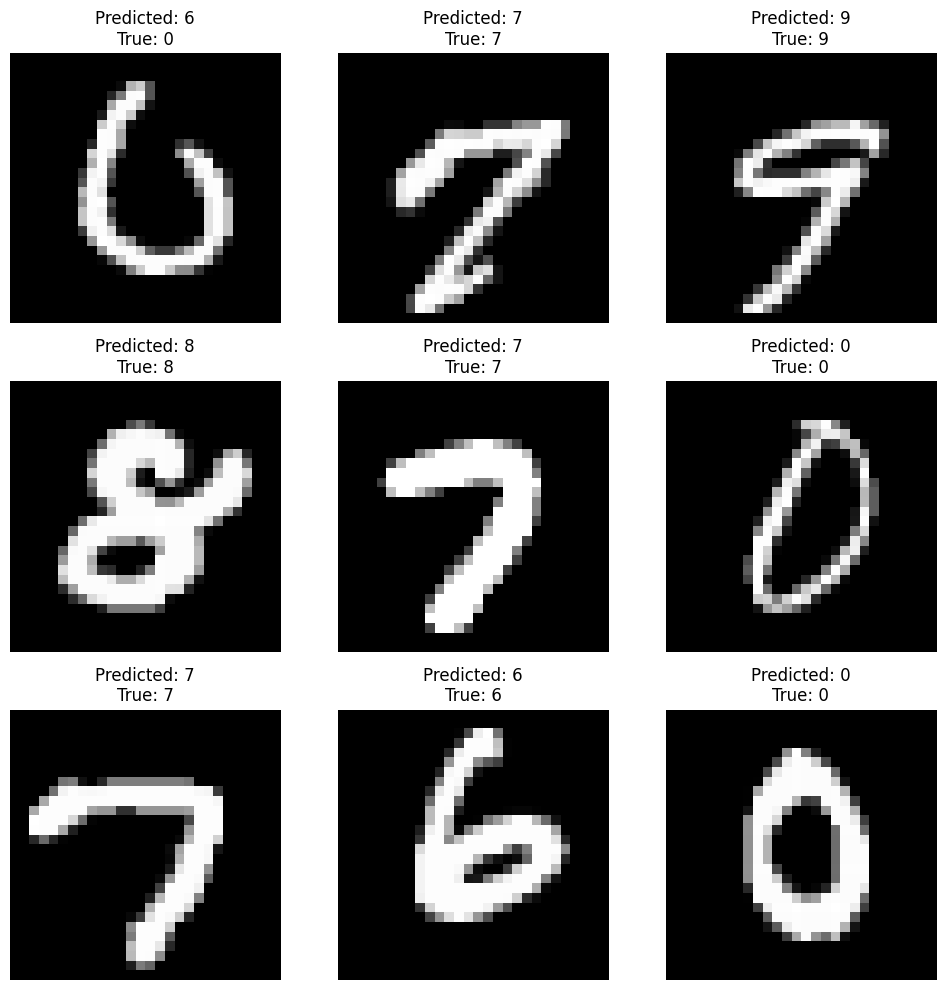

In [56]:
import numpy as np

# Get a batch of images and labels from the validation data
images, labels = next(iter(val_data))

images = images.to(device)
model.eval()
with torch.no_grad():
    outputs = model(images)
    predicted_labels = outputs.argmax(dim=1)

images = images.cpu()
predicted_labels = predicted_labels.cpu()
labels = labels.cpu()

# Plotting the images with their predicted labels
num_images_to_plot = 9  # You can change this number
fig = plt.figure(figsize=(10, 10))
for i in range(num_images_to_plot):
    ax = fig.add_subplot(int(np.ceil(num_images_to_plot / 3)), 3, i + 1)
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Predicted: {predicted_labels[i].item()}\nTrue: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
